<h1>Pneumonia Detector from X-ray</h1>

<h3>Install and import on the instance</h3>

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm opendatasets


In [4]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
import opendatasets as op


<h3>Get the data and copy it to S3</h3>

In [3]:
!pip install -U sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [6]:
op.download('https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images')


100%|██████████| 1.17G/1.17G [00:10<00:00, 120MB/s] 


In [8]:
session = sagemaker.Session()
bucket = session.default_bucket()
region = session.boto_region_name
role = sagemaker.get_execution_role()

os.environ["DEFAULT_S3_BUCKET"] = bucket

In [9]:
%%capture

!aws s3 sync ./labeled-chest-xray-images s3://${DEFAULT_S3_BUCKET}/chestCRXImages/


In [10]:
print(bucket)

s3bucket = os.path.join("s3://", bucket)
print(s3bucket)

s3datapath = os.path.join(s3bucket, "chestCRXImages/chest_xray")
print(s3datapath)

sagemaker-us-east-1-286375333242
s3://sagemaker-us-east-1-286375333242
s3://sagemaker-us-east-1-286375333242/chestCRXImages/chest_xray


<h3>Hyper-parameter Tuning</h3>

In [11]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.01),
    "batch_size": CategoricalParameter([16, 32, 64, 128]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [12]:
estimator = PyTorch(
    entry_point="CNN_training.py",
    base_job_name='CRX_Pneumonia',
    role=role,
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    py_version='py36'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [14]:
os.environ['SM_CHANNEL_TRAINING']=s3datapath
os.environ['SM_MODEL_DIR']=os.path.join(s3datapath, "model")#'s3://udacitysolution/model/'
os.environ['SM_OUTPUT_DATA_DIR']=os.path.join(s3datapath, "output")#'s3://udacitysolution/output/'
tuner.fit({"training": s3datapath})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [23]:
#or find under sagemaker hyper-parameter tuning jobs if kernel dies
latest_tuning_job_name = tuner.latest_tuning_job.name
print(latest_tuning_job_name)

pytorch-training-220921-0404


<h3>Tuning results</h3>


In [24]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=latest_tuning_job_name)

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
1       "32"       0.003989  pytorch-training-220921-0404-001-55d34e19   
0       "32"       0.006130  pytorch-training-220921-0404-002-551b9194   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
1         Completed                 14.0 2022-09-21 04:06:47+00:00   
0         Completed                 12.0 2022-09-21 04:54:43+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
1 2022-09-21 04:46:59+00:00                      2412.0  
0 2022-09-21 05:34:03+00:00                      2360.0

## Imp: If kernel dies, load from sagemaker

In [25]:
BetterTrainingJobName='pytorch-training-220921-0404-002-551b9194'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator


2022-09-21 05:34:06 Starting - Found matching resource for reuse
2022-09-21 05:34:06 Downloading - Downloading input data
2022-09-21 05:34:06 Training - Training image download completed. Training in progress.
2022-09-21 05:34:06 Uploading - Uploading generated training model
2022-09-21 05:34:06 Completed - Resource released due to keep alive period expiry


<h3>Model training with the best hyper-parameters</h3>

In [26]:
best_estimator=tuner.best_estimator()


2022-09-21 05:34:06 Starting - Found matching resource for reuse
2022-09-21 05:34:06 Downloading - Downloading input data
2022-09-21 05:34:06 Training - Training image download completed. Training in progress.
2022-09-21 05:34:06 Uploading - Uploading generated training model
2022-09-21 05:34:06 Completed - Resource released due to keep alive period expiry


In [27]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.0061302077895518114',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"CRX_Pneumonia-2022-09-21-04-04-41-276"',
 'sagemaker_program': '"CNN_training.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-286375333242/CRX_Pneumonia-2022-09-21-04-04-41-276/source/sourcedir.tar.gz"'}

In [47]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['learning_rate'],
                   "epochs" : 5}
hyperparameters

{'batch_size': 32, 'lr': '0.0061302077895518114', 'epochs': 5}

<h3>Setting up debugger and profiler for the training job</h3>

In [48]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [49]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

<h2>Creating an Estimator</h2>

In [58]:
estimator = PyTorch(
    entry_point='CNN_training.py',
    base_job_name='CXR-Pneumonia',
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

<h3>Training the model</h3>

In [59]:
estimator.fit({"training": s3datapath}, wait = True)

2022-09-21 08:11:08 Starting - Starting the training job...
2022-09-21 08:11:34 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-09-21 08:13:08 Downloading - Downloading input data......
2022-09-21 08:14:08 Training - Downloading the training image........................
2022-09-21 08:18:09 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-21 08:18:00,240 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-21 08:18:00,270 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-21 08:18:00,278 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-21 08:18:00,959 sagemaker-training-tool

<h2>Deploy the model</h2>

In [101]:
model_location=estimator.model_data
print("Mode data in case of reload or if the kernel dies before deployment:")
print(model_location)

Mode data in case of reload or if the kernel dies before deployment:
s3://sagemaker-us-east-1-286375333242/CXR-Pneumonia-2022-09-21-08-11-08-385/output/model.tar.gz


In [61]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [62]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [65]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [81]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


------!

In [82]:
endpoint_name = predictor.endpoint_name

print("The endpoint name is:")
print(endpoint_name)

The endpoint name is:
pytorch-inference-2022-09-21-09-11-25-960


<h2>Testing the endpoint and visualizing the results</h2>

./samples/BACTERIA-1351146-0003.jpeg
The X-ray image sent for prediction:


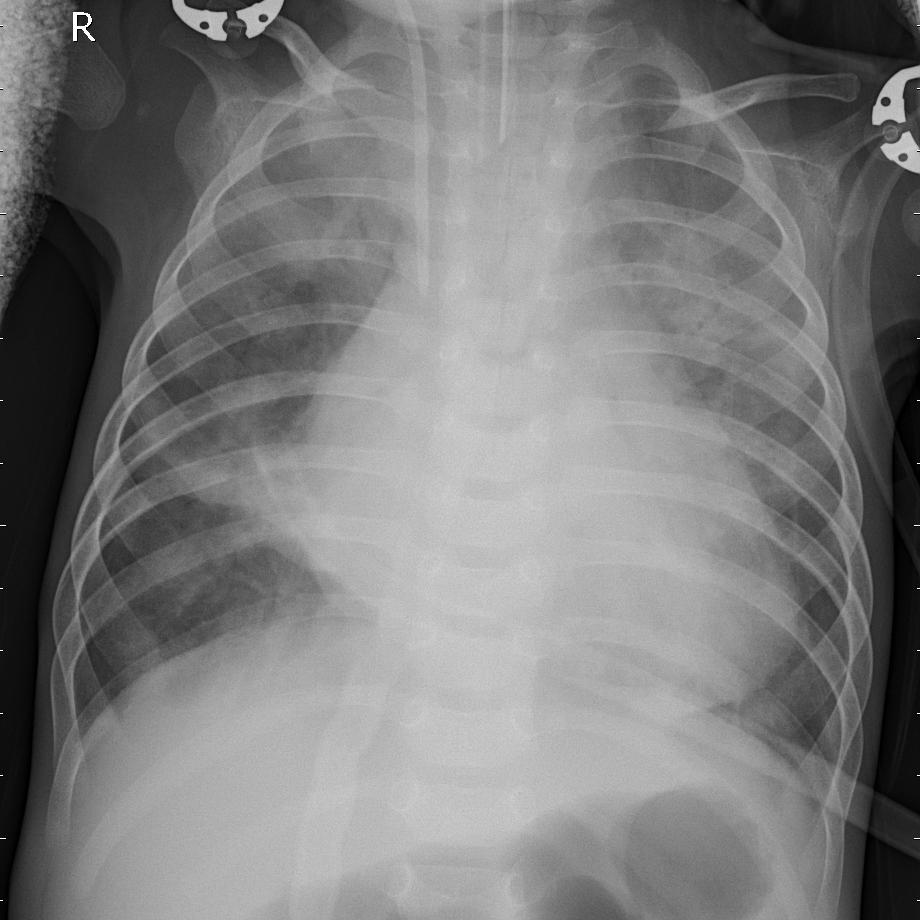

The label of the image is BACTERIA
The prediction given by the machine learning model is PNEUMONIA

./samples/BACTERIA-3060399-0002.jpeg
The X-ray image sent for prediction:


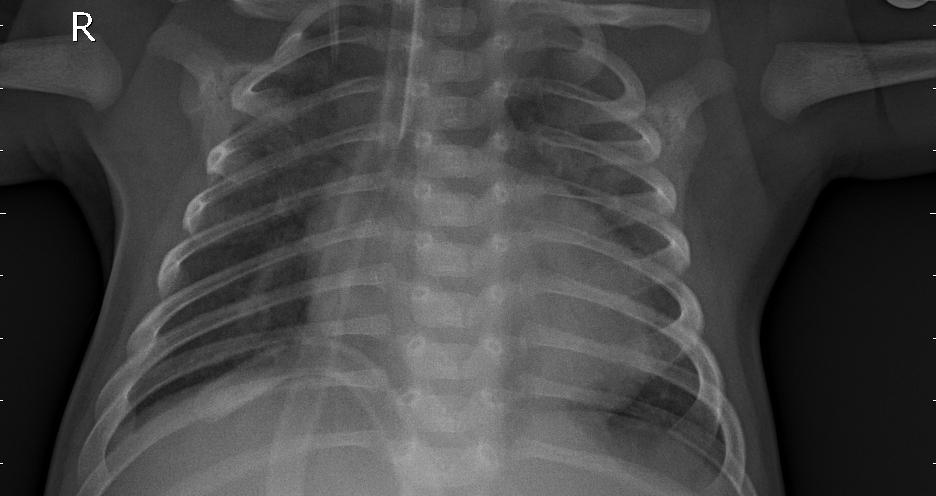

The label of the image is BACTERIA
The prediction given by the machine learning model is PNEUMONIA

./samples/NORMAL-1931427-0001.jpeg
The X-ray image sent for prediction:


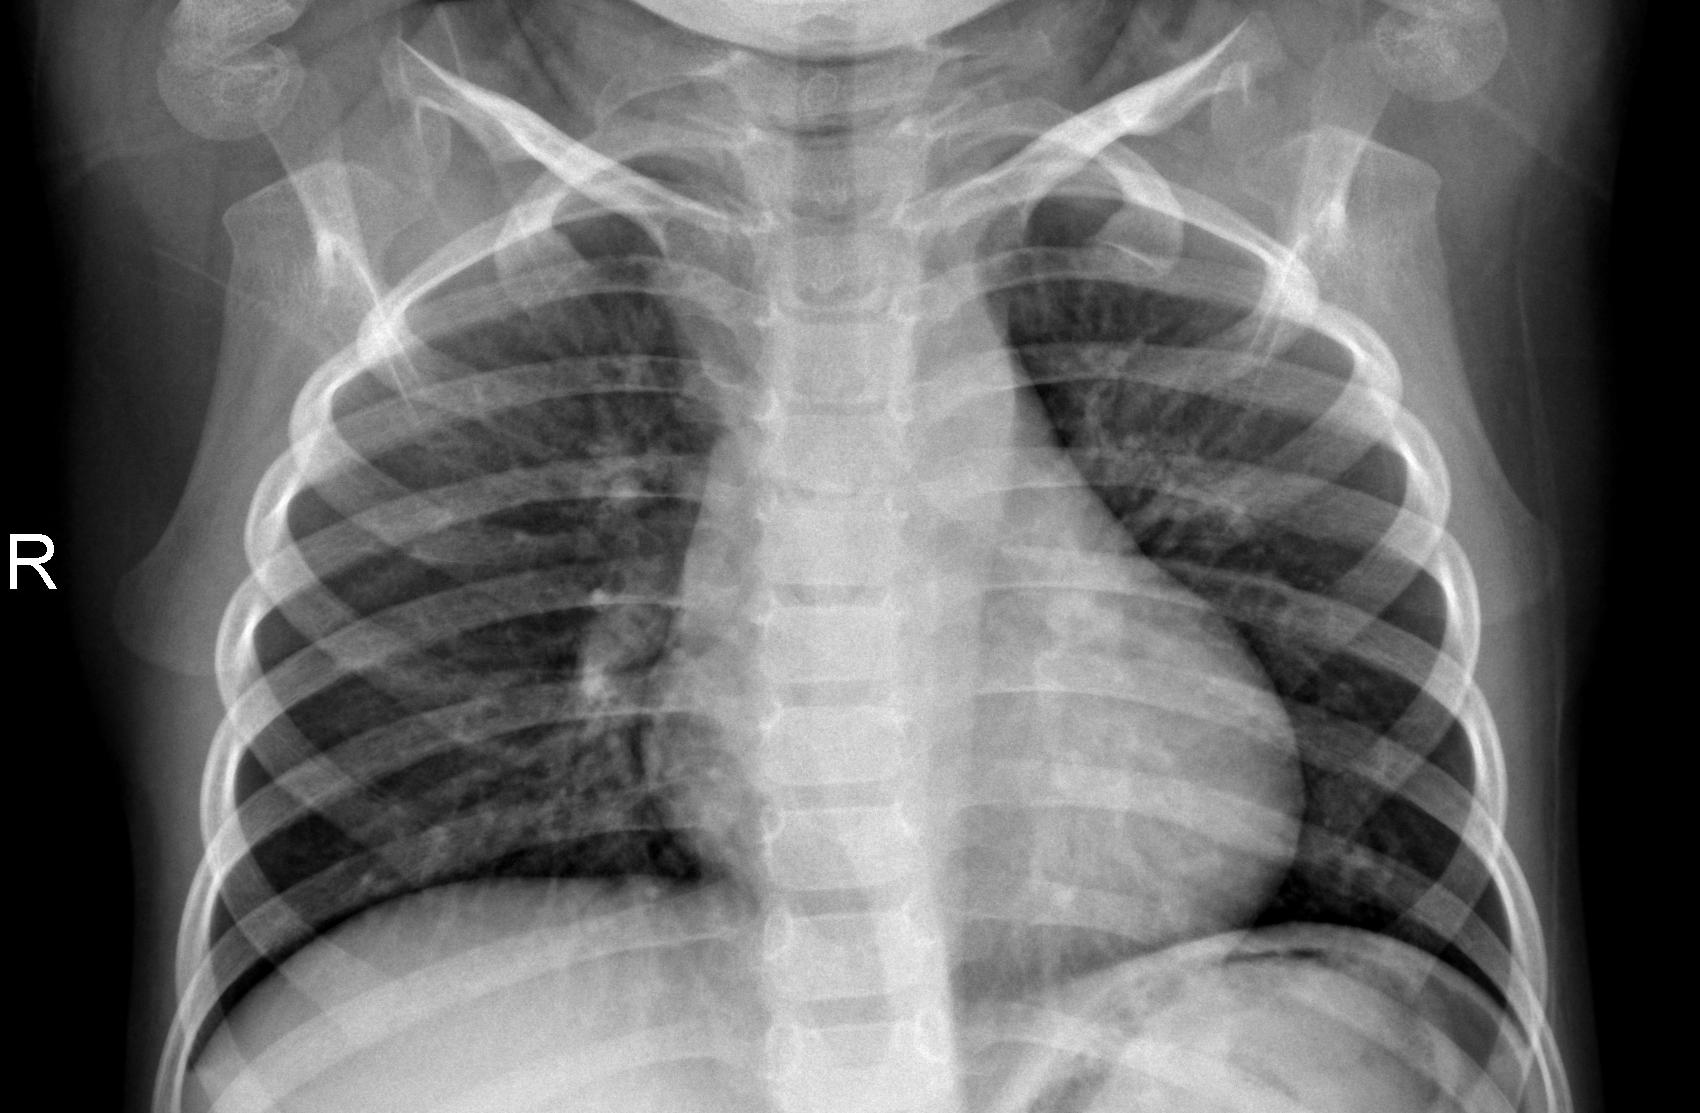

The label of the image is NORMAL
The prediction given by the machine learning model is NORMAL

./samples/NORMAL-8698006-0001.jpeg
The X-ray image sent for prediction:


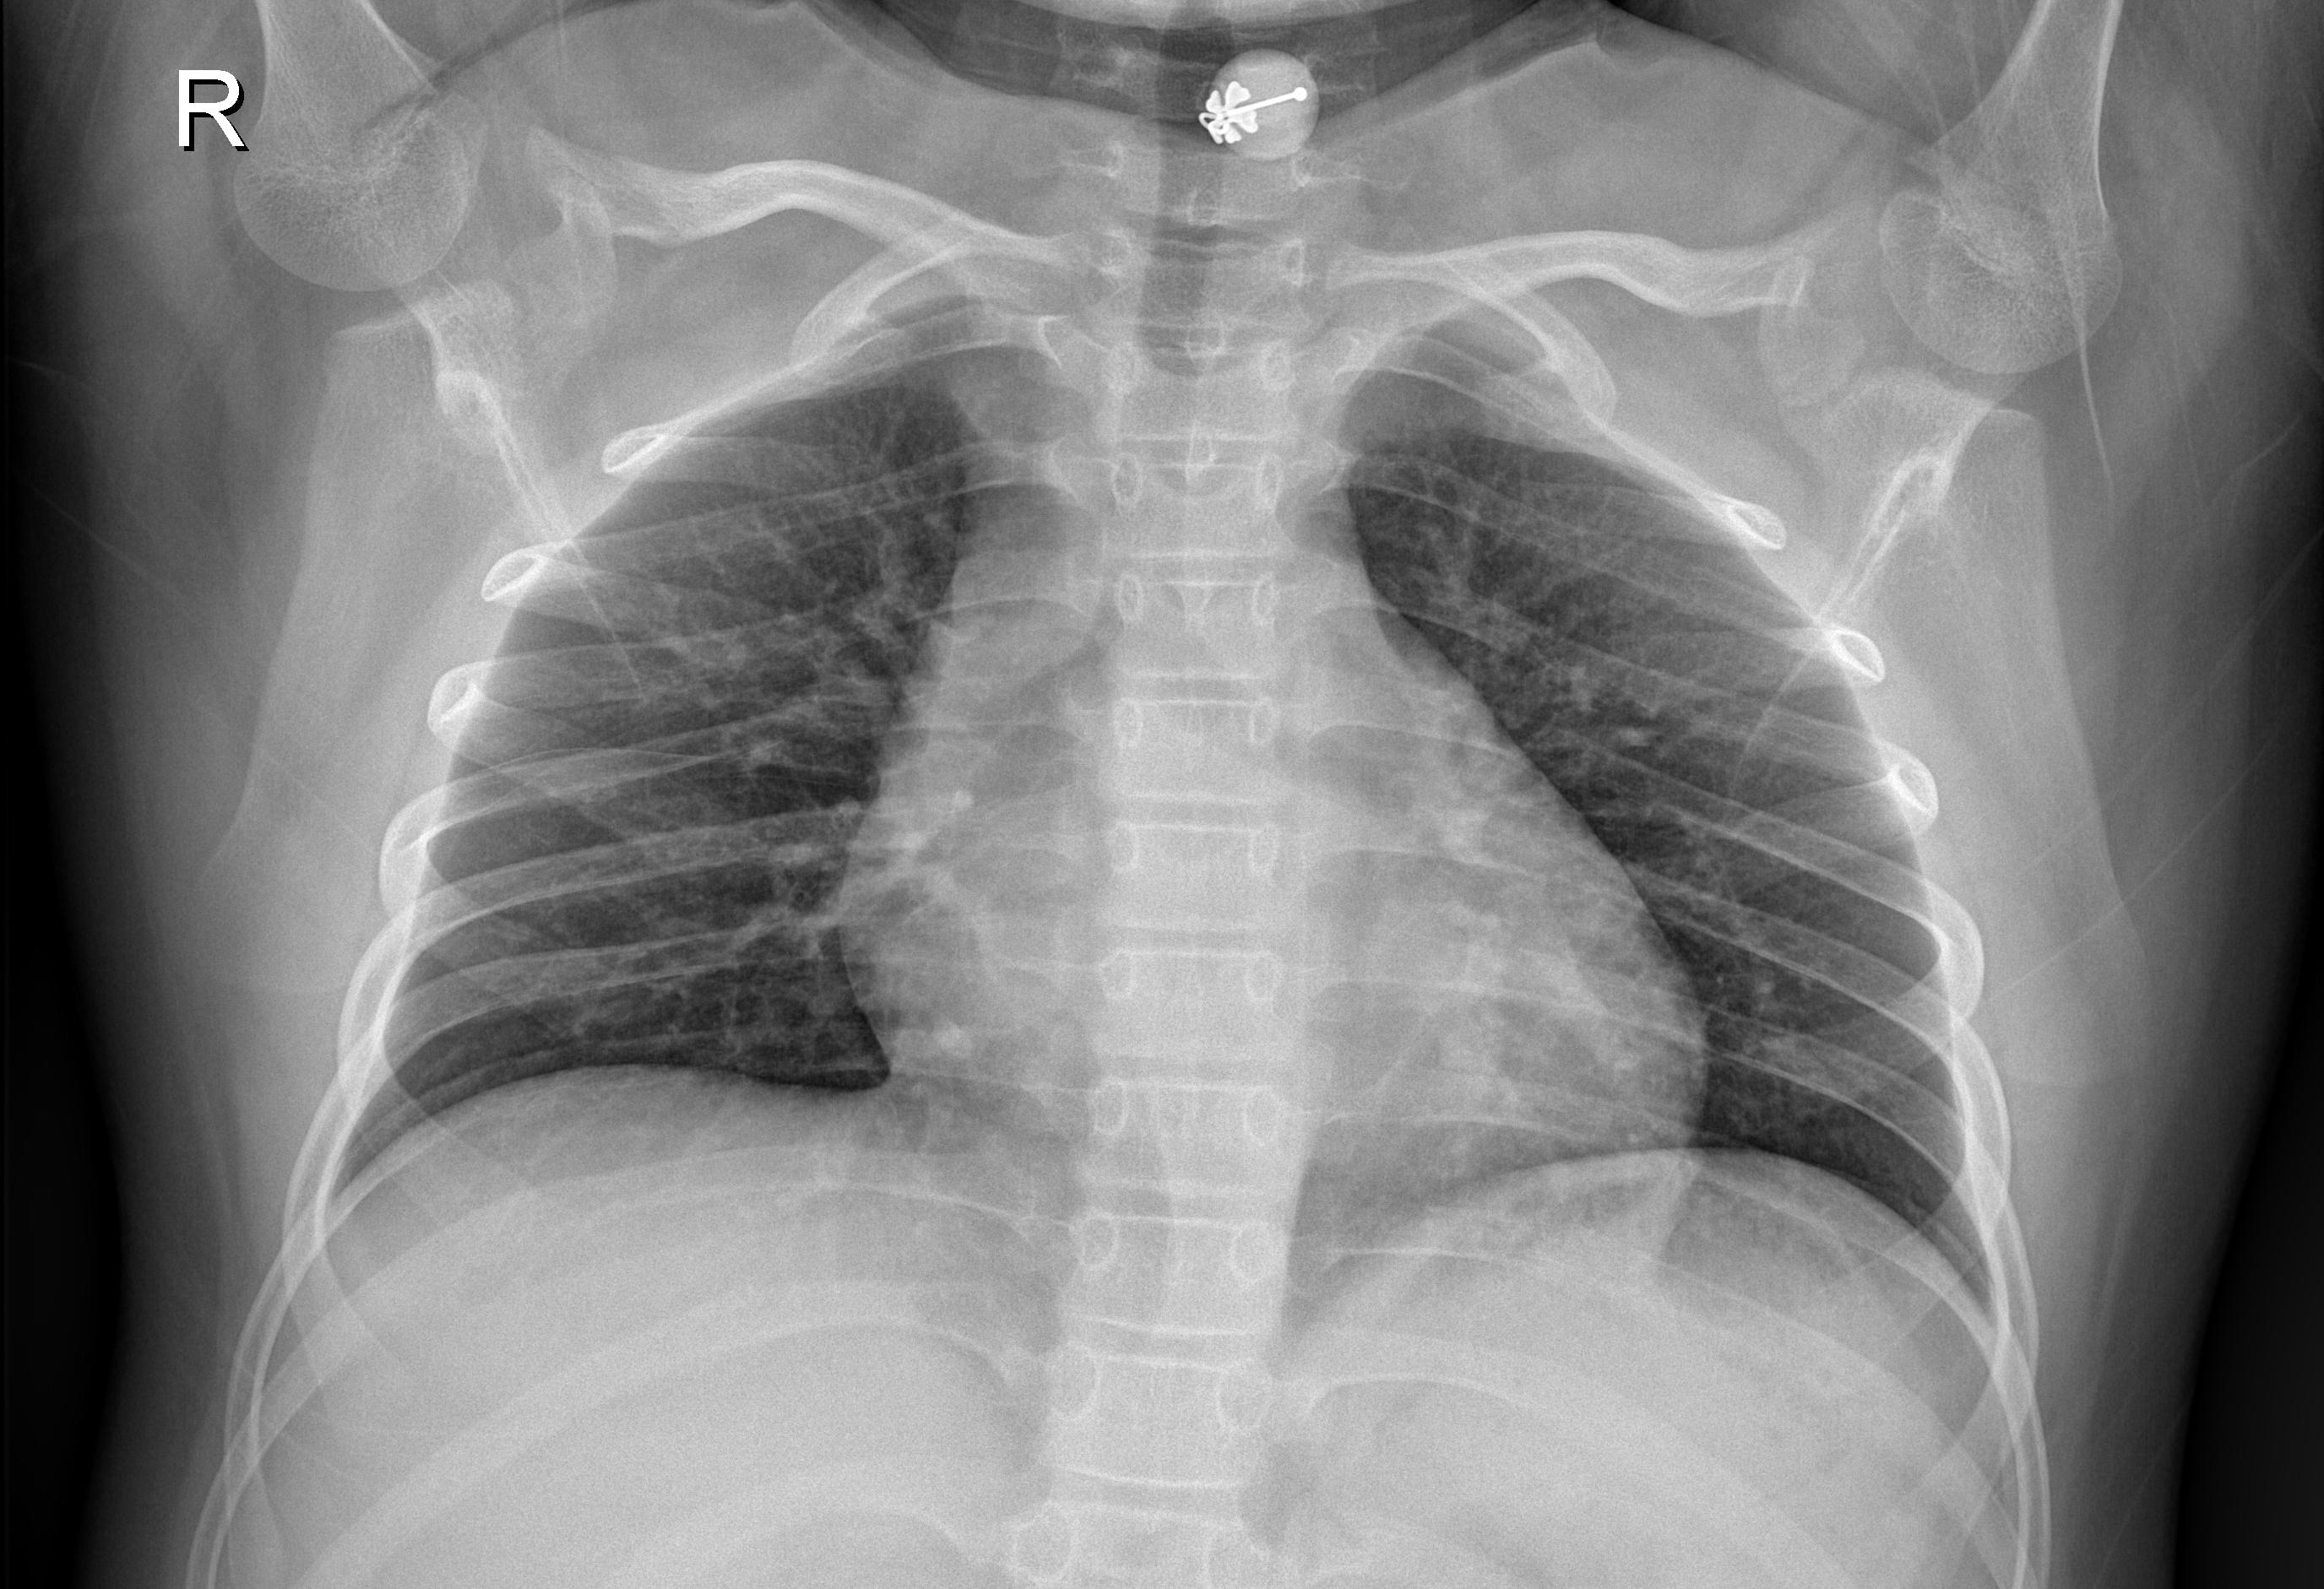

The label of the image is NORMAL
The prediction given by the machine learning model is NORMAL

./samples/VIRUS-1352878-0007.jpeg
The X-ray image sent for prediction:


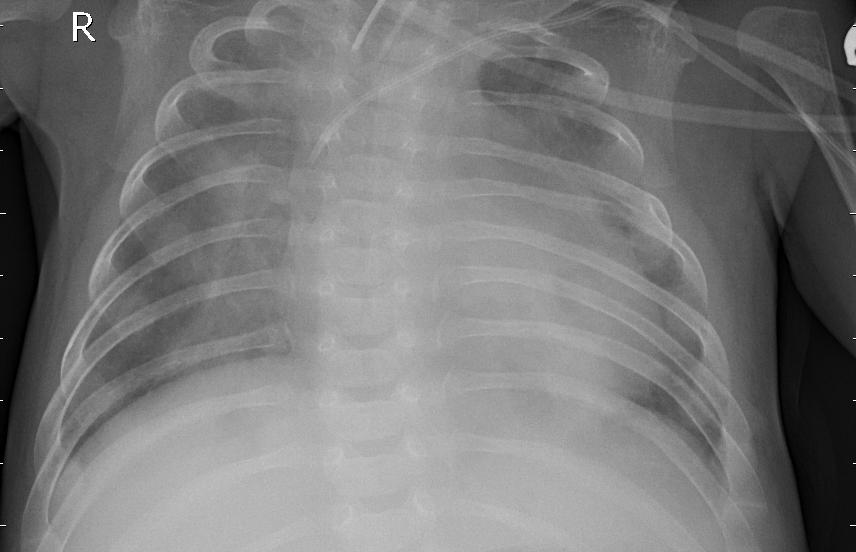

The label of the image is VIRUS
The prediction given by the machine learning model is PNEUMONIA

./samples/VIRUS-3565661-0001.jpeg
The X-ray image sent for prediction:


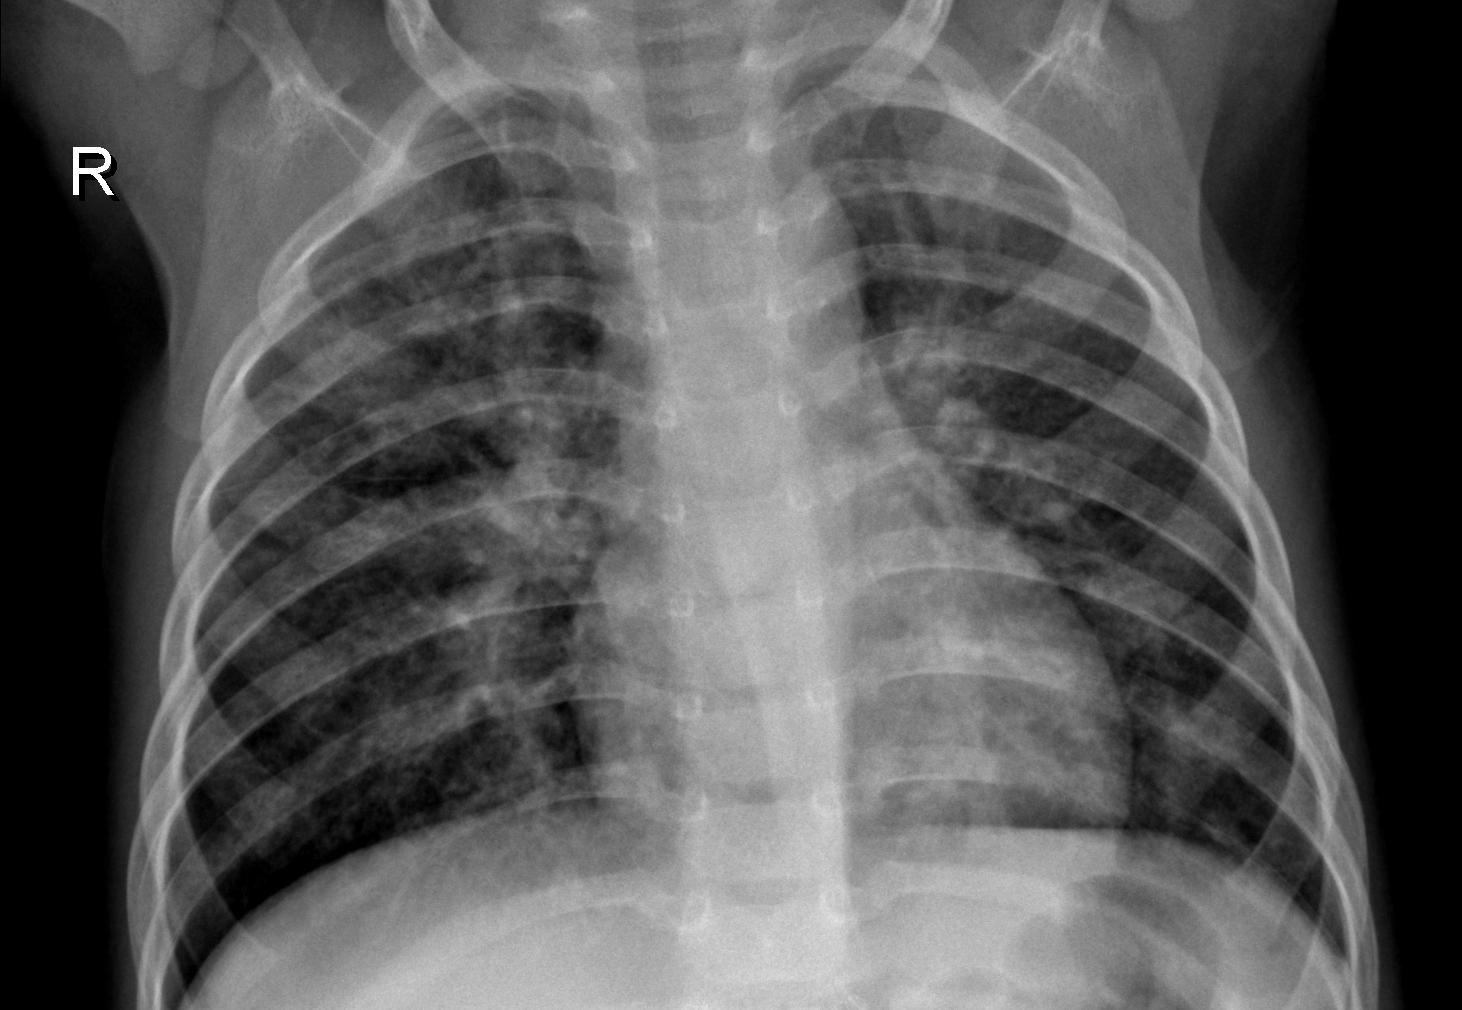

The label of the image is VIRUS
The prediction given by the machine learning model is PNEUMONIA



In [98]:
from sagemaker.serializers import IdentitySerializer

predictor.serializer = IdentitySerializer("image/jpeg")
jpeg_serializer = IdentitySerializer("image/jpeg")


from PIL import Image
import numpy as np

files = [
        './samples/BACTERIA-1351146-0003.jpeg', 
        './samples/BACTERIA-3060399-0002.jpeg', 
        './samples/NORMAL-1931427-0001.jpeg', 
        './samples/NORMAL-8698006-0001.jpeg', 
        './samples/VIRUS-1352878-0007.jpeg', 
        './samples/VIRUS-3565661-0001.jpeg', 
        ]
    
for file in files:
    # Getting labels
    target_str = 'samples/'
    end_str = '-' 
    s_pos = file.index(target_str) + len(target_str)
    e_pos = file.index(end_str) + len(end_str)
    label = file[s_pos:e_pos-1]
    print(file)
    
    
    # Displaying image to be predicted
    img = Image.open(file).convert('RGB')
    print('The X-ray image sent for prediction:')
    display(img)
    
    # Querying endpoint
    image = open(file, 'rb').read()
    response = predictor.predict(image, initial_args={'ContentType':'image/jpeg'})
    prediction = np.argmax(response[0]) + 1 
    prediction = 'NORMAL' if np.argmax(response[0]) == 0 else 'PNEUMONIA'    
    
    print(f'The label of the image is {label}')
    print(f'The prediction given by the machine learning model is {prediction}\n')

<h2>Probability Calibration</h2>